# Sentiment Analysis of Drug Reviews Using Natural Language Processing Techniques

## Problem Statement:

This study applies sentiment analysis and textual pattern extraction on drug reviews to identify not only user sentiment but also key factors such as side effects, ineffectiveness, or condition mismatch that contribute to negative medication experiences.

In [1]:
import pandas as pd
import re
import nltk
import string
import html
import matplotlib.pyplot as plt
import numpy as np
#from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

# download NLTK resources (do only once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab') 
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/niksyareena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/niksyareena/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/niksyareena/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/niksyareena/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/niksyareena/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/niksyareena/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

## Basic Data Cleaning

1. Have basic understanding and cleaning of the data.

In [2]:
#df = pd.read_csv('drugsComTrain_raw.tsv' , sep='\t')
df = pd.read_csv('drugsComTrain_raw.tsv', sep='\t', on_bad_lines='skip')

df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [3]:
df.tail()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10.0,"May 31, 2015",125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1.0,"November 1, 2011",34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2.0,"March 15, 2014",35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10.0,"September 19, 2015",79
161296,215220,Lubiprostone,"Constipation, Chronic","""I&#039;ve had chronic constipation all my adu...",9.0,"December 13, 2014",116


In [4]:
#Basic checks
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   161297 non-null  int64  
 1   drugName     161297 non-null  object 
 2   condition    160398 non-null  object 
 3   review       161297 non-null  object 
 4   rating       161297 non-null  float64
 5   date         161297 non-null  object 
 6   usefulCount  161297 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB


In [5]:
#Check for missing values
df.isna().sum()


Unnamed: 0       0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [6]:
#Remove missing values as it only contributes to ~0.9% of the data
df.dropna(subset=['condition'], inplace=True)
#Double check for missing values
df.isna().sum()

Unnamed: 0     0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [7]:
#Rename columns
df.rename(columns={'Unnamed: 0': 'patient_id'}, inplace=True)

In [8]:
#Check for duplicates
df.duplicated().sum()

np.int64(0)

In [9]:
#Change date to proper format
df['date'] = pd.to_datetime(df['date'], format='%B %d, %Y')


In [10]:
#Final check
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160398 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   patient_id   160398 non-null  int64         
 1   drugName     160398 non-null  object        
 2   condition    160398 non-null  object        
 3   review       160398 non-null  object        
 4   rating       160398 non-null  float64       
 5   date         160398 non-null  datetime64[ns]
 6   usefulCount  160398 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 9.8+ MB


In [11]:
#Create copy of cleaned data
df2=df.copy()

In [12]:
df2.head()

,patient_id,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37


## Text Preprocessing 

1. Sentence Segmentation

In [13]:
from nltk.tokenize import sent_tokenize

pd.set_option('display.max_colwidth', None)

df2['sentences'] = df2['review'].apply(sent_tokenize)
df2[['sentences']].head()

,sentences
0,"[""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""]"
1,"[""My son is halfway through his fourth week of Intuniv., We became concerned when he began this last week, when he started taking the highest dose he will be on., For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.), I called his doctor on Monday morning and she said to stick it out a few days., See how he did at school, and with getting up in the morning., The last two days have been problem free., He is MUCH more agreeable than ever., He is less emotional (a good thing), less cranky., He is remembering all the things he should., Overall his behavior is better., We have tried many different medications and so far this is the most effective.""]"
2,"[""I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects., But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar., When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said., And the period lasted for two weeks., When taking the second pack- same two weeks., And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge., The positive side is that I didn&#039;t have any other side effects., The idea of being period free was so tempting..., Alas.""]"
3,"[""This is my first time using any form of birth control., I&#039;m glad I went with the patch, I have been on it for 8 months., At first It decreased my libido but that subsided., The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control., Other than that in happy with the patch""]"
4,"[""Suboxone has completely turned my life around., I feel healthier, I&#039;m excelling at my job and I always have money in my pocket and my savings account., I had none of those before Suboxone and spent years abusing oxycontin., My paycheck was already spent by the time I got it and I started resorting to scheming and stealing to fund my addiction., All that is history., If you&#039;re ready to stop, there&#039;s a good chance that suboxone will put you on the path of great life again., I have found the side-effects to be minimal compared to oxycontin., I&#039;m actually sleeping better., Slight constipation is about it for me., It truly is amazing., The cost pales in comparison to what I spent on oxycontin.""]"


2. Tokenization

In [14]:
df2['tokens'] = df2['review'].apply(word_tokenize)
df2[['tokens']].head()

,tokens
0,"[``, It, has, no, side, effect, ,, I, take, it, in, combination, of, Bystolic, 5, Mg, and, Fish, Oil, '']"
1,"[``, My, son, is, halfway, through, his, fourth, week, of, Intuniv, ., We, became, concerned, when, he, began, this, last, week, ,, when, he, started, taking, the, highest, dose, he, will, be, on, ., For, two, days, ,, he, could, hardly, get, out, of, bed, ,, was, very, cranky, ,, and, slept, for, nearly, 8, hours, on, a, drive, home, from, school, vacation, (, very, unusual, for, him, ., ), I, called, his, doctor, on, Monday, morning, and, she, said, to, stick, it, out, a, few, days, ., See, how, he, did, at, school, ,, and, with, getting, up, in, ...]"
2,"[``, I, used, to, take, another, oral, contraceptive, ,, which, had, 21, pill, cycle, ,, and, was, very, happy-, very, light, periods, ,, max, 5, days, ,, no, other, side, effects, ., But, it, contained, hormone, gestodene, ,, which, is, not, available, in, US, ,, so, I, switched, to, Lybrel, ,, because, the, ingredients, are, similar, ., When, my, other, pills, ended, ,, I, started, Lybrel, immediately, ,, on, my, first, day, of, period, ,, as, the, instructions, said, ., And, the, period, lasted, for, two, weeks, ., When, taking, the, second, pack-, same, two, weeks, ., And, now, ,, ...]"
3,"[``, This, is, my, first, time, using, any, form, of, birth, control, ., I, &, #, 039, ;, m, glad, I, went, with, the, patch, ,, I, have, been, on, it, for, 8, months, ., At, first, It, decreased, my, libido, but, that, subsided, ., The, only, downside, is, that, it, made, my, periods, longer, (, 5-6, days, to, be, exact, ), I, used, to, only, have, periods, for, 3-4, days, max, also, made, my, cramps, intense, for, the, first, two, days, of, my, period, ,, I, never, had, cramps, before, using, birth, control, ., Other, than, that, in, happy, ...]"
4,"[``, Suboxone, has, completely, turned, my, life, around, ., I, feel, healthier, ,, I, &, #, 039, ;, m, excelling, at, my, job, and, I, always, have, money, in, my, pocket, and, my, savings, account, ., I, had, none, of, those, before, Suboxone, and, spent, years, abusing, oxycontin, ., My, paycheck, was, already, spent, by, the, time, I, got, it, and, I, started, resorting, to, scheming, and, stealing, to, fund, my, addiction, ., All, that, is, history, ., If, you, &, #, 039, ;, re, ready, to, stop, ,, there, &, #, 039, ;, s, a, good, chance, that, suboxone, ...]"


3. Case folding

In [15]:
#lowercasing
df2['tokens_lower'] = df2['tokens'].apply(lambda x: [word.lower() for word in x])
print(df2[['tokens_lower']].head())

#uppercasing
df2['tokens_upper'] = df2['tokens'].apply(lambda x: [word.upper() for word in x])
print(df2[['tokens_upper']].head())



                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           tokens_lower
0                                                                                                                                                                                                                                                                                                                                                                                                               

3. Punctuation Removal

In [16]:
df2['tokens_no_punct'] = df2['tokens_lower'].apply(lambda x: [word for word in x if word not in string.punctuation])
df2 [['tokens_no_punct']].head()

,tokens_no_punct
0,"[``, it, has, no, side, effect, i, take, it, in, combination, of, bystolic, 5, mg, and, fish, oil, '']"
1,"[``, my, son, is, halfway, through, his, fourth, week, of, intuniv, we, became, concerned, when, he, began, this, last, week, when, he, started, taking, the, highest, dose, he, will, be, on, for, two, days, he, could, hardly, get, out, of, bed, was, very, cranky, and, slept, for, nearly, 8, hours, on, a, drive, home, from, school, vacation, very, unusual, for, him, i, called, his, doctor, on, monday, morning, and, she, said, to, stick, it, out, a, few, days, see, how, he, did, at, school, and, with, getting, up, in, the, morning, the, last, two, days, have, been, problem, free, he, ...]"
2,"[``, i, used, to, take, another, oral, contraceptive, which, had, 21, pill, cycle, and, was, very, happy-, very, light, periods, max, 5, days, no, other, side, effects, but, it, contained, hormone, gestodene, which, is, not, available, in, us, so, i, switched, to, lybrel, because, the, ingredients, are, similar, when, my, other, pills, ended, i, started, lybrel, immediately, on, my, first, day, of, period, as, the, instructions, said, and, the, period, lasted, for, two, weeks, when, taking, the, second, pack-, same, two, weeks, and, now, with, third, pack, things, got, even, worse-, my, third, period, lasted, for, two, weeks, and, now, ...]"
3,"[``, this, is, my, first, time, using, any, form, of, birth, control, i, 039, m, glad, i, went, with, the, patch, i, have, been, on, it, for, 8, months, at, first, it, decreased, my, libido, but, that, subsided, the, only, downside, is, that, it, made, my, periods, longer, 5-6, days, to, be, exact, i, used, to, only, have, periods, for, 3-4, days, max, also, made, my, cramps, intense, for, the, first, two, days, of, my, period, i, never, had, cramps, before, using, birth, control, other, than, that, in, happy, with, the, patch, '']"
4,"[``, suboxone, has, completely, turned, my, life, around, i, feel, healthier, i, 039, m, excelling, at, my, job, and, i, always, have, money, in, my, pocket, and, my, savings, account, i, had, none, of, those, before, suboxone, and, spent, years, abusing, oxycontin, my, paycheck, was, already, spent, by, the, time, i, got, it, and, i, started, resorting, to, scheming, and, stealing, to, fund, my, addiction, all, that, is, history, if, you, 039, re, ready, to, stop, there, 039, s, a, good, chance, that, suboxone, will, put, you, on, the, path, of, great, life, again, i, have, found, the, side-effects, to, ...]"


5. Stopword Removal

In [17]:
stop_words = set(stopwords.words('english'))
df2['tokens_no_stop'] = df2['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
df2[['tokens_no_stop']].head()

,tokens_no_stop
0,"[``, It, side, effect, ,, I, take, combination, Bystolic, 5, Mg, Fish, Oil, '']"
1,"[``, My, son, halfway, fourth, week, Intuniv, ., We, became, concerned, began, last, week, ,, started, taking, highest, dose, ., For, two, days, ,, could, hardly, get, bed, ,, cranky, ,, slept, nearly, 8, hours, drive, home, school, vacation, (, unusual, ., ), I, called, doctor, Monday, morning, said, stick, days, ., See, school, ,, getting, morning, ., The, last, two, days, problem, free, ., He, MUCH, agreeable, ever, ., He, less, emotional, (, good, thing, ), ,, less, cranky, ., He, remembering, things, ., Overall, behavior, better, ., We, tried, many, different, medications, far, effective, ., '']"
2,"[``, I, used, take, another, oral, contraceptive, ,, 21, pill, cycle, ,, happy-, light, periods, ,, max, 5, days, ,, side, effects, ., But, contained, hormone, gestodene, ,, available, US, ,, I, switched, Lybrel, ,, ingredients, similar, ., When, pills, ended, ,, I, started, Lybrel, immediately, ,, first, day, period, ,, instructions, said, ., And, period, lasted, two, weeks, ., When, taking, second, pack-, two, weeks, ., And, ,, third, pack, things, got, even, worse-, third, period, lasted, two, weeks, &, #, 039, ;, end, third, week-, I, still, daily, brown, discharge, ., The, positive, side, I, &, #, 039, ...]"
3,"[``, This, first, time, using, form, birth, control, ., I, &, #, 039, ;, glad, I, went, patch, ,, I, 8, months, ., At, first, It, decreased, libido, subsided, ., The, downside, made, periods, longer, (, 5-6, days, exact, ), I, used, periods, 3-4, days, max, also, made, cramps, intense, first, two, days, period, ,, I, never, cramps, using, birth, control, ., Other, happy, patch, '']"
4,"[``, Suboxone, completely, turned, life, around, ., I, feel, healthier, ,, I, &, #, 039, ;, excelling, job, I, always, money, pocket, savings, account, ., I, none, Suboxone, spent, years, abusing, oxycontin, ., My, paycheck, already, spent, time, I, got, I, started, resorting, scheming, stealing, fund, addiction, ., All, history, ., If, &, #, 039, ;, ready, stop, ,, &, #, 039, ;, good, chance, suboxone, put, path, great, life, ., I, found, side-effects, minimal, compared, oxycontin, ., I, &, #, 039, ;, actually, sleeping, better, ., Slight, constipation, ., It, truly, amazing, ., The, cost, pales, comparison, I, spent, ...]"


7. Lemmetization

In [18]:
lemmatizer = WordNetLemmatizer()

df2['lemmatized_tokens'] = df2['tokens_no_stop'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
df2[['lemmatized_tokens']].head()


,lemmatized_tokens
0,"[``, It, side, effect, ,, I, take, combination, Bystolic, 5, Mg, Fish, Oil, '']"
1,"[``, My, son, halfway, fourth, week, Intuniv, ., We, became, concerned, began, last, week, ,, started, taking, highest, dose, ., For, two, day, ,, could, hardly, get, bed, ,, cranky, ,, slept, nearly, 8, hour, drive, home, school, vacation, (, unusual, ., ), I, called, doctor, Monday, morning, said, stick, day, ., See, school, ,, getting, morning, ., The, last, two, day, problem, free, ., He, MUCH, agreeable, ever, ., He, less, emotional, (, good, thing, ), ,, less, cranky, ., He, remembering, thing, ., Overall, behavior, better, ., We, tried, many, different, medication, far, effective, ., '']"
2,"[``, I, used, take, another, oral, contraceptive, ,, 21, pill, cycle, ,, happy-, light, period, ,, max, 5, day, ,, side, effect, ., But, contained, hormone, gestodene, ,, available, US, ,, I, switched, Lybrel, ,, ingredient, similar, ., When, pill, ended, ,, I, started, Lybrel, immediately, ,, first, day, period, ,, instruction, said, ., And, period, lasted, two, week, ., When, taking, second, pack-, two, week, ., And, ,, third, pack, thing, got, even, worse-, third, period, lasted, two, week, &, #, 039, ;, end, third, week-, I, still, daily, brown, discharge, ., The, positive, side, I, &, #, 039, ...]"
3,"[``, This, first, time, using, form, birth, control, ., I, &, #, 039, ;, glad, I, went, patch, ,, I, 8, month, ., At, first, It, decreased, libido, subsided, ., The, downside, made, period, longer, (, 5-6, day, exact, ), I, used, period, 3-4, day, max, also, made, cramp, intense, first, two, day, period, ,, I, never, cramp, using, birth, control, ., Other, happy, patch, '']"
4,"[``, Suboxone, completely, turned, life, around, ., I, feel, healthier, ,, I, &, #, 039, ;, excelling, job, I, always, money, pocket, saving, account, ., I, none, Suboxone, spent, year, abusing, oxycontin, ., My, paycheck, already, spent, time, I, got, I, started, resorting, scheming, stealing, fund, addiction, ., All, history, ., If, &, #, 039, ;, ready, stop, ,, &, #, 039, ;, good, chance, suboxone, put, path, great, life, ., I, found, side-effects, minimal, compared, oxycontin, ., I, &, #, 039, ;, actually, sleeping, better, ., Slight, constipation, ., It, truly, amazing, ., The, cost, pale, comparison, I, spent, ...]"


8. Raw Data Cleaning

In [19]:
#clean raw text for transformer based model 

def clean_review_text(text):

    text = html.unescape(text)  #converts &#039; to ', &quot; to ", etc.
    
    #remove escaped characters and line breaks
    text = re.sub(r'\\r\\n|\\n|\\r', ' ', text)  # Remove line breaks
    text = re.sub(r'\\t', ' ', text)  # Remove tabs
    
    #remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    #remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    #remove excessive punctuation 
    text = re.sub(r'[!]{2,}', '!', text)
    text = re.sub(r'[?]{2,}', '?', text)
    text = re.sub(r'[.]{3,}', '...', text)
    
    #remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s!?.,;:()\-\']', ' ', text)
    
    #fix spacing issues
    text = re.sub(r'\s+', ' ', text)  # Multiple spaces to single space
    text = text.strip()  # Remove leading/trailing spaces
    
    #handle common abbreviations for better VADER understanding
    text = re.sub(r'\bmg\b', 'milligrams', text, flags=re.IGNORECASE)
    text = re.sub(r'\bdr\.?\b', 'doctor', text, flags=re.IGNORECASE)
    text = re.sub(r'\bw/\b', 'with', text, flags=re.IGNORECASE)
    text = re.sub(r'\bb/c\b', 'because', text, flags=re.IGNORECASE)
    
    return text

df2['review_cleaned'] = df2['review'].apply(clean_review_text)


In [20]:
df2.head()

,patient_id,drugName,condition,review,rating,date,usefulCount,sentences,tokens,tokens_lower,tokens_upper,tokens_no_punct,tokens_no_stop,lemmatized_tokens,review_cleaned
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""",9.0,2012-05-20,27,"[""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""]","[``, It, has, no, side, effect, ,, I, take, it, in, combination, of, Bystolic, 5, Mg, and, Fish, Oil, '']","[``, it, has, no, side, effect, ,, i, take, it, in, combination, of, bystolic, 5, mg, and, fish, oil, '']","[``, IT, HAS, NO, SIDE, EFFECT, ,, I, TAKE, IT, IN, COMBINATION, OF, BYSTOLIC, 5, MG, AND, FISH, OIL, '']","[``, it, has, no, side, effect, i, take, it, in, combination, of, bystolic, 5, mg, and, fish, oil, '']","[``, It, side, effect, ,, I, take, combination, Bystolic, 5, Mg, Fish, Oil, '']","[``, It, side, effect, ,, I, take, combination, Bystolic, 5, Mg, Fish, Oil, '']","It has no side effect, I take it in combination of Bystolic 5 milligrams and Fish Oil"
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective.""",8.0,2010-04-27,192,"[""My son is halfway through his fourth week of Intuniv., We became concerned when he began this last week, when he started taking the highest dose he will be on., For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.), I called his doctor on Monday morning and she said to stick it out a few days., See how he did at school, and with getting up in the morning., The last two days have been problem free., He is MUCH more agreeable than ever., He is less emotional (a good thing), less cranky., He is remembering all the things he should., Overall his behavior is better., We have tried many different medications and so far this is the most effective.""]","[``, My, son, is, halfway, through, his, fourth, week, of, Intuniv, ., We, became, concerned, when, he, began, this, last, week, ,, when, he, started, taking, the, highest, dose, he, will, be, on, ., For, two, days, ,, he, could, hardly, get, out, of, bed, ,, was, very, cranky, ,, and, slept, for, nearly, 8, hours, on, a, drive, home, from, school, vacation, (, very, unusual, for, him, ., ), I, called, his, doctor, on, Monday, morning, and, she, said, to, stick, it, out, a, few, days, ., See, how, he, did, at, school, ,, and, with, getting, up, in, ...]","[``, my, son, is, halfway, through, his, fourth, week, of, intuniv, ., we, became, concerned, when, he, began, this, last, week, ,, when, he, started, taking, the, highest, dose, he, will, be, on, ., for, two, days, ,, he, could, hardly, get, out, of, bed, ,, was, very, cranky, ,, and, slept, for, nearly, 8, hours, on, a, drive, home, from, school, vacation, (, very, unusual, for, him, ., ), i, called, his, doctor, on, monday, morning, and, she, said, to, stick, it, out, a, few, days, ., see, how, he, did, at, school, ,, and, with, getting, up, in, ...]","[``, MY, SON, IS, HALFWAY, THROUGH, HIS, FOURTH, WEEK, OF, INTUNIV, ., WE, BECAME, CONCERNED, WHEN, HE, BEGAN, THIS, LAST, WEEK, ,, WHEN, HE, STARTED, TAKING, THE, HIGHEST, DOSE, HE, WILL, BE, ON, ., FOR, TWO, DAYS, ,, HE, COULD, HARDLY, GET,

## Feature Enginerring: TF-IDF Vectorization

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df2['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens)))

print(tfidf_matrix)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5928298 stored elements and shape (160398, 5000)>
  Coords	Values
  (0, 2408)	0.14861945694897097
  (0, 3965)	0.14935380705228565
  (0, 1560)	0.14920099239869503
  (0, 4341)	0.1623978889904569
  (0, 1042)	0.3689761435882895
  (0, 853)	0.5049457917268754
  (0, 2791)	0.23796598802761867
  (0, 1822)	0.5249022632333503
  (0, 3049)	0.42861152845956935
  (1, 2906)	0.054385128887622564
  (1, 4074)	0.11727617986187659
  (1, 2072)	0.16925886536268406
  (1, 1904)	0.14283326612329028
  (1, 4831)	0.10260137541192973
  (1, 2389)	0.17632910252250755
  (1, 4816)	0.23276090653600331
  (1, 629)	0.10211263676382432
  (1, 1085)	0.13406003942858546
  (1, 643)	0.0993442029424361
  (1, 2506)	0.14474222252497024
  (1, 4159)	0.055658593426456834
  (1, 4344)	0.05206915663990341
  (1, 2169)	0.15445852259034587
  (1, 1464)	0.0772389607740074
  (1, 1873)	0.09660409403812281
  :	:
  (160397, 7)	0.16016292911651567
  (160397, 4472)	0.08700970007910311
  

## Sentiment Analysis

### Opinion Mining

In [26]:
#dependency parsing for opinion-target pairs
#for exploratory purposes, we will only use 30k rows to avoid slow processing

import spacy
nlp = spacy.load('en_core_web_sm')

# Define function
def extract_opinion_pairs_bulk(texts):
    all_pairs = []
    for doc in nlp.pipe(texts, batch_size=100, disable=["ner"]):  
        pairs = []
        if not doc:
            all_pairs.append(pairs)
            continue
        for token in doc:
            if token.pos_ == "ADJ":
                if token.head.pos_ == "NOUN":
                    pairs.append((token.text.lower(), token.head.text.lower()))
                for child in token.children:
                    if child.pos_ == "NOUN":
                        pairs.append((token.text.lower(), child.text.lower()))
        all_pairs.append(pairs)
    return all_pairs

subset_df = df2.iloc[:30000].copy()

subset_df['opinion_pairs'] = extract_opinion_pairs_bulk(subset_df['review_cleaned'].astype(str))

df2['opinion_pairs'] = None  # Initialize column first
df2.update(subset_df[['opinion_pairs']])  



In [27]:
df2['opinion_pairs'].head(10)

0                                                                                                                                                                                                                                                                                      []
1                                                                   [(fourth, week), (last, week), (highest, dose), (unusual, vacation), (few, days), (last, days), (free, problem), (agreeable, much), (emotional, thing), (good, thing), (many, medications), (different, medications)]
2    [(oral, contraceptive), (light, periods), (other, effects), (other, pills), (first, day), (second, pack-), (same, weeks), (same, pack-), (third, pack), (third, period), (third, week-), (daily, discharge), (brown, discharge), (positive, side), (other, effects), (free, period)]
3                                                                                                                                                         

In [28]:
#observe top opinion and target words

from collections import Counter

pairs_flat = [pair for pairs in df2['opinion_pairs'] if pairs for pair in pairs]
opinion_words = [op for op, _ in pairs_flat]
target_words = [target for _, target in pairs_flat]

print(pd.Series(Counter(opinion_words)).nlargest(10))
print(pd.Series(Counter(target_words)).nlargest(10))


first     5921
few       3382
other     3208
only      2452
old       2415
bad       2356
last      2346
severe    2262
good      1819
more      1690
dtype: int64
effects    3833
pain       3091
time       2726
day        2461
years      2208
days       2175
months     1785
week       1645
month      1566
thing      1532
dtype: int64


In [24]:
#opinion lexicons
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

df2['vader_score'] = df2['review_cleaned'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df2['vader_label'] = df2['vader_score'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))
df2[['review_cleaned', 'vader_label', 'vader_score']].head(10)

,review_cleaned,vader_label,vader_score
0,"It has no side effect, I take it in combination of Bystolic 5 milligrams and Fish Oil",negative,-0.2960
1,"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. We have tried many different medications and so far this is the most effective.",positive,0.9174
2,"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it's the end of the third week- I still have daily brown discharge. The positive side is that I didn't have any other side effects. The idea of being period free was so tempting... Alas.",positive,0.6160
3,"This is my first time using any form of birth control. I'm glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch",positive,0.7184
4,"Suboxone has completely turned my life around. I feel healthier, I'm excelling at my job and I always have money in my pocket and my savings account. I had none of those before Suboxone and spent years abusing oxycontin. My paycheck was already spent by the time I got it and I started resorting to scheming and stealing to fund my addiction. All that is history. If you're ready to stop, there's a good chance that suboxone will put you on the path of great life again. I have found the side-effects to be minimal compared to oxycontin. I'm actually sleeping better. Slight constipation is about it for me. It truly is amazing. The cost pales in comparison to what I spent on oxycontin.",positive,0.9403
5,"2nd day on 5mg started to work with rock hard erections however experianced headache, lower bowel preassure. 3rd day erections would wake me up hurt! Leg ankles aches severe lower bowel preassure like you need to go 2 but can't! Enjoyed the initial rockhard erections but not at these side effects or 230 for months supply! I'm 50 work out 3Xs a week. Not worth side effects!",negative,-0.8972
6,"He pulled out, but he cummed a bit in me. I took the Plan B 26 hours later, and took a pregnancy test two weeks later - - I'm pregnant.",neutral,0.0000
7,"Abilify changed my life. There is hope. I was on Zoloft and Clonidine when I first started Abilify at the age of 15.. Zoloft for depression and Clondine to manage my complete rage. My moods were out of control. I was depressed and hopeless one second and then mean, irrational, and full of rage the next. My doctor. prescribed me 2mg of Abilify and from that point on I feel like I have been cured though I know I'm not.. Bi-polar disorder is a constant battle. I know Abilify works for me because I have tried to get off it and lost complete control over my emotions. Went back on it and I was golden again

### Aspect-Based Sentiment Analysis (ABSA)

In [25]:
#for exploratory purposes, we will only use 30k rows to save time and computing resources
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nlp = spacy.load("en_core_web_sm")
analyzer = SentimentIntensityAnalyzer()

# Function to extract aspects and sentiment per aspect
def absa_extract_aspect_sentiment(text):
    doc = nlp(text)
    aspect_sentiments = []

    for chunk in doc.noun_chunks:
        aspect = chunk.text.lower()
        # Extract surrounding sentence to estimate polarity
        sent_text = chunk.sent.text
        sentiment_score = analyzer.polarity_scores(sent_text)['compound']
        sentiment = 'positive' if sentiment_score >= 0.05 else 'negative' if sentiment_score <= -0.05 else 'neutral'
        aspect_sentiments.append((aspect, sentiment))
    
    return aspect_sentiments

absa_subset = df2.iloc[:30000].copy()

# Step 2: Apply ABSA on the subset
absa_subset['aspect_sentiment_label'] = absa_subset['review_cleaned'].apply(absa_extract_aspect_sentiment)

df2['aspect_sentiment_label'] = None 
df2.update(absa_subset[['aspect_sentiment_label']])


In [26]:
from collections import Counter

all_aspects = [aspect for row in df2['aspect_sentiment_label'] if row is not None for (aspect, _) in row]
common_aspects = Counter(all_aspects).most_common(15)

# View as DataFrame
aspect_df = pd.DataFrame(common_aspects, columns=['aspect', 'count'])
print(aspect_df)


             aspect   count
0                 i  158731
1                it   57842
2                me   21256
3              this   10088
4              that   10059
5               you    7803
6             which    4811
7              they    4060
8         my doctor    3381
9         my period    2660
10               he    2651
11          my life    2511
12  this medication    2493
13             what    2464
14          nothing    2063


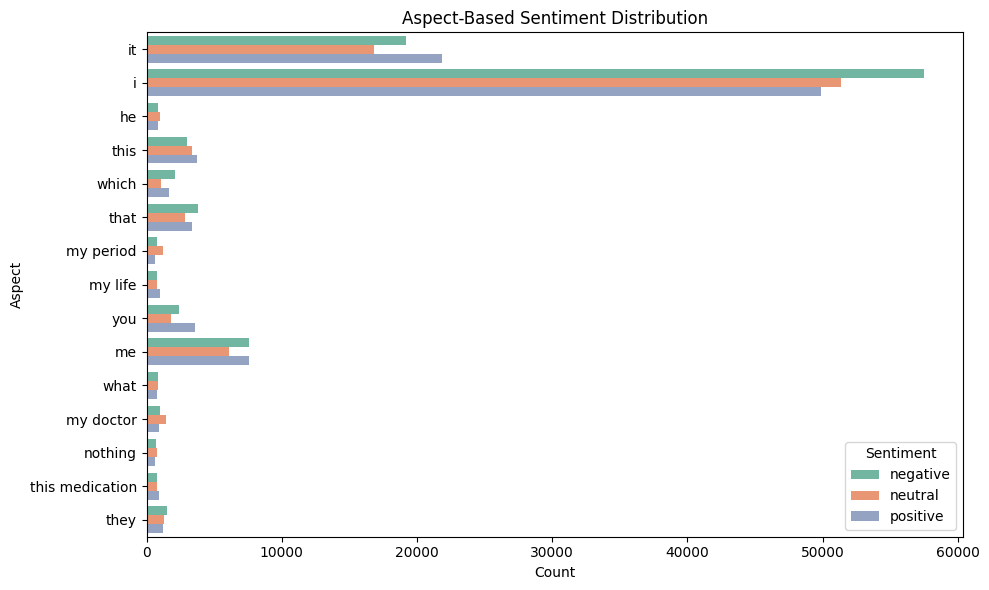

In [27]:
# Flatten aspects and sentiments
import seaborn as sns
import matplotlib.pyplot as plt

aspect_sentiment_flat = []
for row in df2['aspect_sentiment_label']:
    if row is not None:
        aspect_sentiment_flat.extend(row)

# Create DataFrame
absa_df = pd.DataFrame(aspect_sentiment_flat, columns=['aspect', 'sentiment'])

# Plot top 15 aspects by sentiment count


top_aspects = absa_df['aspect'].value_counts().nlargest(15).index
plot_data = absa_df[absa_df['aspect'].isin(top_aspects)]

plt.figure(figsize=(10, 6))
sns.countplot(data=plot_data, y='aspect', hue='sentiment', palette='Set2')
plt.title('Aspect-Based Sentiment Distribution')
plt.xlabel('Count')
plt.ylabel('Aspect')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


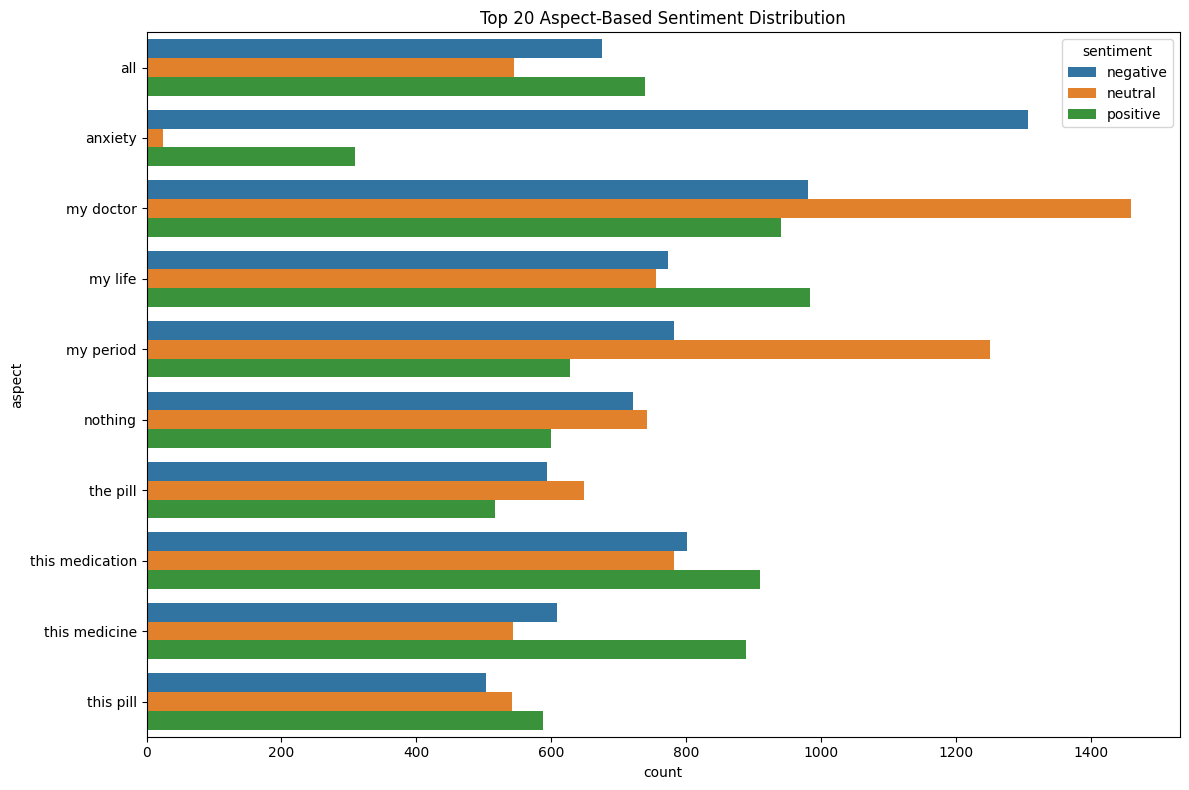

In [28]:
# Remove unhelpful aspects
stop_aspects = ['i', 'it', 'me', 'you', 'he', 'they', 'this', 'that', 'which', 'what','he', 'she', 'they', 'them']
filtered_df = absa_df[~absa_df['aspect'].isin(stop_aspects)]

# Get top 20 most frequent aspects overall
top_aspects = (
    filtered_df['aspect'].value_counts()
    .nlargest(10)
    .index
)

# Keep only those top aspects
filtered_df_top = filtered_df[filtered_df['aspect'].isin(top_aspects)]

# Group and count
grouped_df = filtered_df_top.groupby(['aspect', 'sentiment']).size().reset_index(name='count')

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.barplot(data=grouped_df, y='aspect', x='count', hue='sentiment')
plt.title('Top 20 Aspect-Based Sentiment Distribution')
plt.tight_layout()
plt.show()


## Model Development & Evaluation

### Machine Learning Approach with SVM

In [29]:
#1.Define sentiment labels based on rating 

df2['sentiment_label1'] = df2['rating'].apply(lambda x: 'positive' if x >= 7 else ('neutral' if x >= 5 else 'negative'))

df2.head()

,patient_id,drugName,condition,review,rating,date,usefulCount,sentences,tokens,tokens_lower,tokens_upper,tokens_no_punct,tokens_no_stop,lemmatized_tokens,review_cleaned,opinion_pairs,sentiment_label1
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""",9.0,2012-05-20,27,"[""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""]","[``, It, has, no, side, effect, ,, I, take, it, in, combination, of, Bystolic, 5, Mg, and, Fish, Oil, '']","[``, it, has, no, side, effect, ,, i, take, it, in, combination, of, bystolic, 5, mg, and, fish, oil, '']","[``, IT, HAS, NO, SIDE, EFFECT, ,, I, TAKE, IT, IN, COMBINATION, OF, BYSTOLIC, 5, MG, AND, FISH, OIL, '']","[``, it, has, no, side, effect, i, take, it, in, combination, of, bystolic, 5, mg, and, fish, oil, '']","[``, It, side, effect, ,, I, take, combination, Bystolic, 5, Mg, Fish, Oil, '']","[``, It, side, effect, ,, I, take, combination, Bystolic, 5, Mg, Fish, Oil, '']","It has no side effect, I take it in combination of Bystolic 5 milligrams and Fish Oil",[],positive
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective.""",8.0,2010-04-27,192,"[""My son is halfway through his fourth week of Intuniv., We became concerned when he began this last week, when he started taking the highest dose he will be on., For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.), I called his doctor on Monday morning and she said to stick it out a few days., See how he did at school, and with getting up in the morning., The last two days have been problem free., He is MUCH more agreeable than ever., He is less emotional (a good thing), less cranky., He is remembering all the things he should., Overall his behavior is better., We have tried many different medications and so far this is the most effective.""]","[``, My, son, is, halfway, through, his, fourth, week, of, Intuniv, ., We, became, concerned, when, he, began, this, last, week, ,, when, he, started, taking, the, highest, dose, he, will, be, on, ., For, two, days, ,, he, could, hardly, get, out, of, bed, ,, was, very, cranky, ,, and, slept, for, nearly, 8, hours, on, a, drive, home, from, school, vacation, (, very, unusual, for, him, ., ), I, called, his, doctor, on, Monday, morning, and, she, said, to, stick, it, out, a, few, days, ., See, how, he, did, at, school, ,, and, with, getting, up, in, ...]","[``, my, son, is, halfway, through, his, fourth, week, of, intuniv, ., we, became, concerned, when, he, began, this, last, week, ,, when, he, started, taking, the, highest, dose, he, will, be, on, ., for, two, days, ,, he, could, hardly, get, out, of, bed, ,, was, very, cranky, ,, and, slept, for, nearly, 8, hours, on, a, drive, home, from, school, vacation, (, very, unusual, for, him, ., ), i, called, his, doctor, on, monday, morning, and, she, said, to, stick, it, out, a, few, days, ., see, how, he, did, at, school, ,, and, with, getting, up, in, ...]","[``, MY, SON, IS, HALFWAY, THROUGH, HIS, FOURTH, WEEK, OF, INTUNIV, ., WE, BECAME, CONCERNED, WHEN, HE, BEGAN, THIS, LAST, WEEK, ,, WHEN, HE, STARTED, TAKING, THE, HIGHEST, DOSE, HE, WILL, BE, ON, .,

In [30]:
#check for class imbalances
df2['sentiment_label1'].value_counts()


sentiment_label1
positive    106310
negative     39828
neutral      14260
Name: count, dtype: int64

In [31]:

# Define a mapping from label to integer
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

# Apply the mapping to a new column
df2['sentiment_label1_encoded'] = df2['sentiment_label1'].map(label_map)


In [28]:
#Sample same 30K rows for both models
sample_df = df2[['review_cleaned', 'sentiment_label1', 'sentiment_label1_encoded','lemmatized_tokens']].dropna().sample(n=30000, random_state=42)

In [33]:
#reimplement TF-IDF vectorization for the sample
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(sample_df['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens)))

In [ ]:
#model SVM without kfold cross-validation
from sklearn.model_selection import train_test_split # For single split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score # For detailed report and accuracy

X_features = tfidf_matrix 
y_labels = sample_df['sentiment_label1'].values

X_train, X_test, y_train, y_test = train_test_split(
    X_features, 
    y_labels, 
    test_size=0.2,  # 20% for testing, 80% for training
    random_state=42, 
    stratify=y_labels
)

svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

print("=== SVM Performance (Single Train-Test Split) ===")
print(f"Overall Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(report)


=== SVM Performance (Single Train-Test Split) ===
Overall Accuracy: 0.6758

Classification Report:
              precision    recall  f1-score   support

    negative       0.60      0.67      0.63      1474
     neutral       0.20      0.42      0.27       551
    positive       0.90      0.71      0.79      3975

    accuracy                           0.68      6000
   macro avg       0.56      0.60      0.56      6000
weighted avg       0.76      0.68      0.71      6000



In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import pandas as pd


X_tfidf = tfidf_matrix
y = sample_df['sentiment_label1'].values 

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics
all_metrics = []

for train_index, test_index in skf.split(X_tfidf, y):
    X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = y[train_index], y[test_index]

    svm = SVC(kernel='linear', class_weight='balanced')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    # Get metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average=None, labels=np.unique(y), zero_division=0
    )
    accuracy = accuracy_score(y_test, y_pred)

    # Store per-class metrics
    for i, label in enumerate(np.unique(y)):
        all_metrics.append({
            'label': label,
            'precision': precision[i],
            'recall': recall[i],
            'f1': f1[i],
            'accuracy': accuracy
        })

# Convert to DataFrame
metrics_df = pd.DataFrame(all_metrics)

# Compute average per class
avg_metrics = metrics_df.groupby('label').mean()

print("\n=== Average Classification Report Across Folds ===")
print(avg_metrics.round(4))



=== Average Classification Report Across Folds ===
          precision  recall      f1  accuracy
label                                        
negative     0.5894  0.6640  0.6244     0.671
neutral      0.1962  0.4215  0.2677     0.671
positive     0.8923  0.7083  0.7897     0.671


### Transformer Based Appraoch with DistilBert

In [ ]:
# Step 3: After restart, verify installations
import accelerate
import transformers
print(f"Accelerate version: {accelerate.__version__}")
print(f"Transformers version: {transformers.__version__}")

# Step 4: Check if accelerate is properly detected
from transformers.utils import is_accelerate_available
print(f"Accelerate available: {is_accelerate_available()}")



In [33]:
# 1. Imports
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np
import torch
from torch.nn import CrossEntropyLoss

train_df, test_df = train_test_split(sample_df, test_size=0.2, stratify=sample_df['sentiment_label1_encoded'])


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['sentiment_label1_encoded']),
    y=train_df['sentiment_label1_encoded']
)
class_weights = torch.tensor(class_weights, dtype=torch.float)


tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize(example):
    return tokenizer(example['review_cleaned'], truncation=True, padding='max_length')

train_df = train_df.rename(columns={"sentiment_label1_encoded": "labels"})
test_df = test_df.rename(columns={"sentiment_label1_encoded": "labels"})

train_dataset = Dataset.from_pandas(train_df).map(tokenize, batched=True)
test_dataset = Dataset.from_pandas(test_df).map(tokenize, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])



Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [38]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Step 5: Custom Trainer with weighted loss
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # Added **kwargs
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        weights = class_weights.to(logits.device)
        loss_fn = CrossEntropyLoss(weight=weights)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

# Optional: Add metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
# Step 6: TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    load_best_model_at_end=True
)

# Step 7: Trainer
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Step 8: Train
trainer.train()

/tmp/ipykernel_1694/3465488271.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedLossTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.793900,0.800137,0.803833,0.794564,0.803833,0.790848
2,0.679700,0.817225,0.814833,0.817200,0.814833,0.815785
3,0.489600,1.088705,0.815167,0.827588,0.815167,0.820913


TrainOutput(global_step=9000, training_loss=0.6793091278076172, metrics={'train_runtime': 1276.3268, 'train_samples_per_second': 56.412, 'train_steps_per_second': 7.051, 'total_flos': 9537822793728000.0, 'train_loss': 0.6793091278076172, 'epoch': 3.0})

In [41]:
results_df = pd.DataFrame([results])
results_df = results_df[[
    'eval_loss', 'eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1'
]].round(4)

print("Evaluation Results (Weighted Loss):")
display(results_df)


Evaluation Results (Weighted Loss):


,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1
0,0.8001,0.8038,0.7946,0.8038,0.7908


In [42]:
model.save_pretrained("distilbert_sentiment_model")
tokenizer.save_pretrained("distilbert_sentiment_model")


('distilbert_sentiment_model/tokenizer_config.json',
 'distilbert_sentiment_model/special_tokens_map.json',
 'distilbert_sentiment_model/vocab.txt',
 'distilbert_sentiment_model/added_tokens.json',
 'distilbert_sentiment_model/tokenizer.json')

In [43]:
import shutil
from IPython.display import FileLink

shutil.make_archive("distilbert_sentiment_model", 'zip', "distilbert_sentiment_model")

FileLink("distilbert_sentiment_model.zip")

/distilbert_sentiment_model.zip

## Part 2: Extracting Negative Review Factors 

### Filtering Out Negative Reviews

In [32]:
negative_reviews = df2[df2['sentiment_label1'] == 'negative']


In [33]:
from textblob import TextBlob

# Extract noun phrases
negative_reviews.loc[:, 'noun_phrases'] = negative_reviews['review_cleaned'].apply(lambda x: TextBlob(x).noun_phrases)

# Display a few examples
negative_reviews[['review_cleaned', 'noun_phrases']].head(10)


/var/folders/68/hprt_lq14j15tgjr6zxrgmch0000gn/T/ipykernel_36563/1839966267.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews.loc[:, 'noun_phrases'] = negative_reviews['review_cleaned'].apply(lambda x: TextBlob(x).noun_phrases)


,review_cleaned,noun_phrases
5,"2nd day on 5mg started to work with rock hard erections however experianced headache, lower bowel preassure. 3rd day erections would wake me up hurt! Leg ankles aches severe lower bowel preassure like you need to go 2 but can't! Enjoyed the initial rockhard erections but not at these side effects or 230 for months supply! I'm 50 work out 3Xs a week. Not worth side effects!","[hard erections, bowel preassure, day erections, leg, ankles aches, bowel preassure, ca n't, enjoyed, initial rockhard erections, worth side]"
6,"He pulled out, but he cummed a bit in me. I took the Plan B 26 hours later, and took a pregnancy test two weeks later - - I'm pregnant.","[plan b, pregnancy test, 'm pregnant]"
8,I Ve had nothing but problems with the Keppera : constant shaking in my arms legs pins needles feeling in my arms legs severe light headedness no appetite etc.,"[ve, keppera, arms legs pins needles feeling, arms legs, severe light headedness, appetite etc]"
12,"I had Crohn's with a resection 30 years ago and have been mostly in remission since. Have recently had a bad flare and narrowing at the anastomosis and need to be on medication, but haven't found one that I can handle. Asacol gave me such serious body aching and fatigue that I could not function. Pentasa immediately gave me heart palpitations and arrhythmias so I had to discontinue it.","[crohn, have, bad flare, asacol, such serious body, pentasa, heart palpitations]"
13,"Have a little bit of a lingering cough from a cold. Not giving me much trouble except keeps me up at night. I heard this was good so I took so I could get some sleep. Helped tremendously with the cough but then I was having bad stomach cramps and diarrhea. I hadn't eaten anything that should have upset my stomach and it didn't really feel like a bug so I looked up side effects for Delsym. Now I wish I had done that first because I probably wouldn't have taken it. So, while it worked for my cough I still didn't get any sleep due to the stomach issues.","[have, helped, bad stomach cramps, n't eaten, delsym, stomach issues]"
14,"Started Nexplanon 2 months ago because I have a minimal amount of contraception's I can take due to my inability to take the hormone that is used in most birth controls. I'm trying to give it time because it is one of my only options right now. But honestly if I had options I'd get it removed. I've never had acne problems in my life, and immediately broke out after getting it implanted. Sex drive is completely gone, and I used to have sex with my boyfriend a few days a week, now its completely forced and not even fun for me anymore. I mean I'm on birth control because I like having sex but don't want to get pregnant, why take a birth control that takes away sex? Very unhappy and hope that I get it back with time or I'm getting it removed.","[started nexplanon, contraception 's, acne problems, sex, birth control, birth control]"
24,Do not use the cream that comes with this. It turned my hoo-ha into a burning ring of fire. It is 1 am and I have to work tomorrow. It's going to be a sleepless night for me,[sleepless night]
33,The burning is out of control about 20 minutes after inserting it . Sat in the bath trying to get this stuff out . This is awful,[sat]
36,SO MUCH PAIN! In the last 2 years I have suffered with a brain tumour so have been in a LOT of pain to the point of morphine everyday for a year. Then I had brain surgery...but the pain from this pill came pretty close! In serious pain to the point of blacking out hot and cold shivers and just sat in pain feeling like trapped wind indigestion it's just.. Ahhhh! Don't take this!,"[so much pain, brain tumour, lot, brain surgery ..., serious pain, cold shivers, pain feeling, ahhhh]"
38,I have taken this at least 5-6 times for the last 10 years. I have had major problems with it since the first time. Causing me MAJOR FATIGUE. The last time I took it was 3 year's ago and I had very severe cramps and not having e

#### Phrase Extraction

In [34]:
from collections import Counter

# Flatten the list of noun phrases
all_phrases = [phrase for phrases in negative_reviews['noun_phrases'] for phrase in phrases]

# Count frequencies
phrase_freq = Counter(all_phrases)

# Show top 20 phrases
phrase_freq.most_common(20)


[('birth control', 3557),
 ("ca n't", 2352),
 ('mood swings', 1596),
 ('sex drive', 1479),
 ('weight gain', 1404),
 ('was', 1043),
 ('took', 1042),
 ('never', 1030),
 ('er', 1020),
 ("n't work", 958),
 ('side effect', 811),
 ('have', 763),
 ('horrible', 746),
 ('not', 731),
 ('mirena', 712),
 ('blood pressure', 707),
 ('nexplanon', 686),
 ('bc', 639),
 ('well', 615),
 ('iud', 611)]

### Top 20 Most Common Words in Negative Reviews

day        12913
taking     12907
months     11871
pain       11321
ve         11239
like       11217
started    10826
days       10387
just        9711
doctor      9444
time        9359
effects     9035
pill        8986
took        8606
got         7975
weeks       7757
feel        7712
did         7401
month       7312
period      7100
dtype: int64


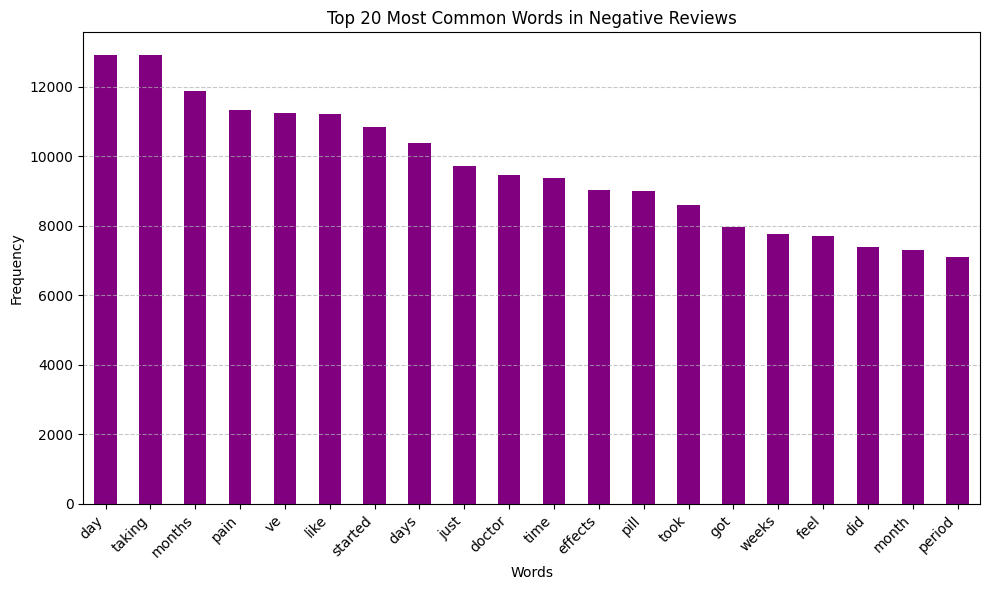

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=20)  # 20 most common words

# Fit and transform
X_counts = vectorizer.fit_transform(negative_reviews['review_cleaned'])

# Convert to DataFrame
word_freq_df = pd.DataFrame(X_counts.toarray(), columns=vectorizer.get_feature_names_out())
top_words = word_freq_df.sum().sort_values(ascending=False)

print(top_words)

# Visiualisation
plt.figure(figsize=(10, 6))
top_words.head(20).plot(kind='bar', color='purple')
plt.title('Top 20 Most Common Words in Negative Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Top 20 TF-IDF Weighted Words in Negative Reviews
Difference:

**Top 20 Most Common Words**: Simply shows which words appear the most, even if they're generic.

**Top 20 TF-IDF Weighted Words**: Shows which words are both frequent and unique to negative reviews—highlighting the specific complaints or themes that set them apart from general chatter.

taking     0.108465
day        0.105035
pain       0.102700
months     0.099142
like       0.094598
ve         0.093418
days       0.089688
effects    0.088738
started    0.087575
just       0.085001
doctor     0.084539
took       0.084441
time       0.083765
did        0.077053
weeks      0.073782
pill       0.073228
got        0.071908
feel       0.071359
month      0.065005
period     0.057506
dtype: float64


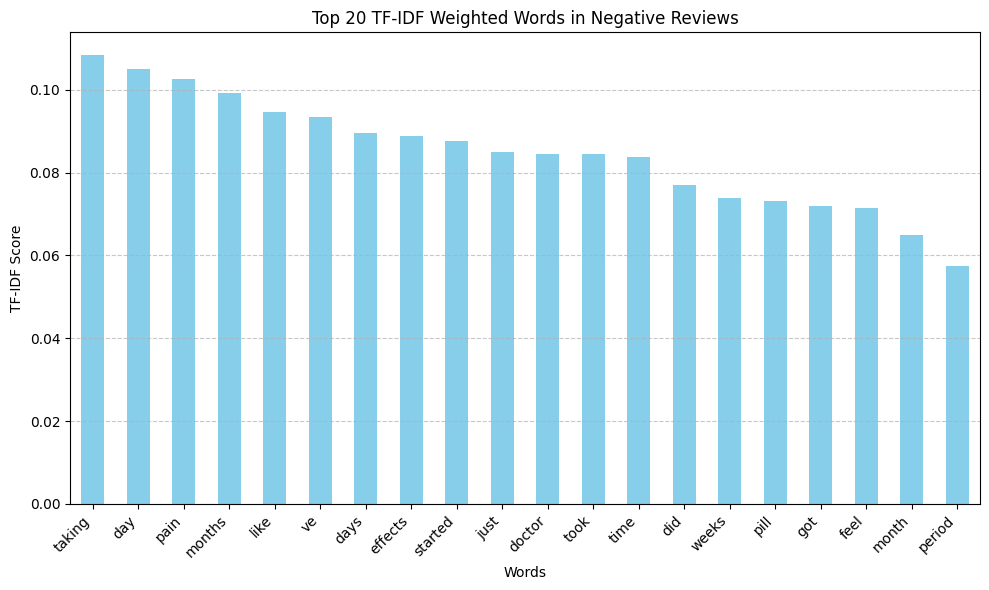

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=20)

# Fit and transform
X_tfidf = tfidf_vectorizer.fit_transform(negative_reviews['review_cleaned'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
top_tfidf_words = tfidf_df.mean().sort_values(ascending=False)

print(top_tfidf_words)

plt.figure(figsize=(10, 6))
top_tfidf_words.head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 TF-IDF Weighted Words in Negative Reviews')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Top 20 Most Common Bigrams in Negative Reviews
**Bigrams** (2 worded phrases) and **trigrams** (3 worded phrases) capture common phrases (like “birth control” or “side effects”), revealing more specific complaint patterns in the reviews. They provide a clearer picture of the actual issues being discussed, rather than isolated words.

birth control        4913
mood swings          2753
weight gain          1908
feel like            1849
sex drive            1798
felt like            1736
started taking       1560
stopped taking       1371
blood pressure       1160
don know              906
months ago            875
stop taking           861
taking pill           856
panic attacks         771
doctor prescribed     712
really bad            710
years old             692
years ago             684
yeast infection       671
doctor said           646
dtype: int64


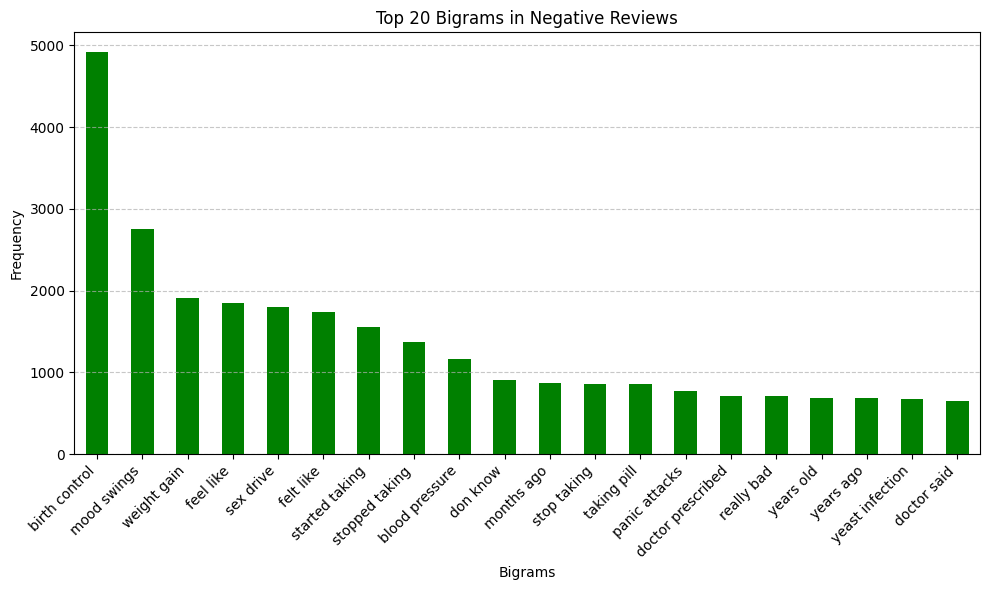

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize Bigram Vectorizer
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20)

# Fit and transform
X_bigrams = bigram_vectorizer.fit_transform(negative_reviews['review_cleaned'])

# Convert to DataFrame
bigram_freq_df = pd.DataFrame(X_bigrams.toarray(), columns=bigram_vectorizer.get_feature_names_out())

# Sum up frequencies
top_bigrams = bigram_freq_df.sum().sort_values(ascending=False)

# Display top 20 bigrams
print(top_bigrams)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_bigrams.plot(kind='bar', color='green')
plt.title('Top 20 Bigrams in Negative Reviews')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Top 20 TF-IDF Weighted Bigrams in Negative Reviews

birth control        0.072715
mood swings          0.046442
feel like            0.034723
weight gain          0.033697
felt like            0.033473
sex drive            0.031808
started taking       0.028676
stopped taking       0.026928
blood pressure       0.019866
don know             0.018974
stop taking          0.017618
months ago           0.017257
taking pill          0.015324
doctor prescribed    0.014957
panic attacks        0.014703
really bad           0.014260
years ago            0.014029
years old            0.013757
doctor said          0.013219
yeast infection      0.013173
dtype: float64


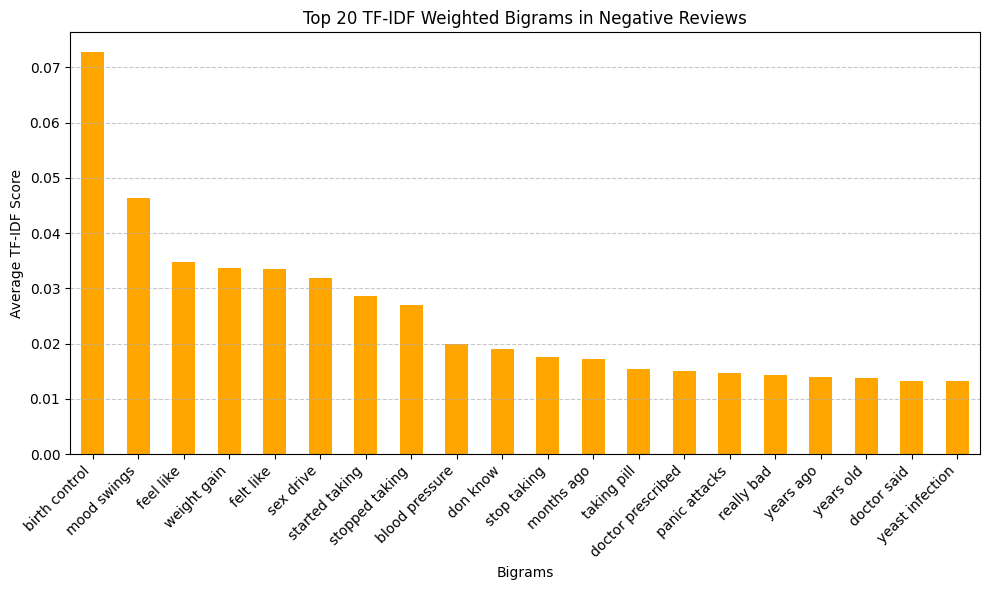

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize Bigram TF-IDF Vectorizer
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20)

# Fit and transform
X_bigrams_tfidf = bigram_tfidf_vectorizer.fit_transform(negative_reviews['review_cleaned'])

# Convert to DataFrame
bigram_tfidf_df = pd.DataFrame(X_bigrams_tfidf.toarray(), columns=bigram_tfidf_vectorizer.get_feature_names_out())

# Calculate average TF-IDF score for each bigram
top_bigrams_tfidf = bigram_tfidf_df.mean().sort_values(ascending=False)

# Display top 20 bigrams by TF-IDF weight
print(top_bigrams_tfidf)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_bigrams_tfidf.plot(kind='bar', color='orange')
plt.title('Top 20 TF-IDF Weighted Bigrams in Negative Reviews')
plt.xlabel('Bigrams')
plt.ylabel('Average TF-IDF Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Top 20 Most Used Trigrams in Negative Reviews

birth control pills        252
birth control pill         238
high blood pressure        231
taking birth control       228
ortho tri cyclen           189
gained 10 pounds           178
worst birth control        173
mood swings depression     162
felt like going            157
gained 20 pounds           156
form birth control         155
anxiety panic attacks      154
horrible mood swings       153
birth control months       152
flu like symptoms          133
started taking pill        129
don feel like              126
recommend birth control    123
birth control ve           123
terrible mood swings       123
dtype: int64


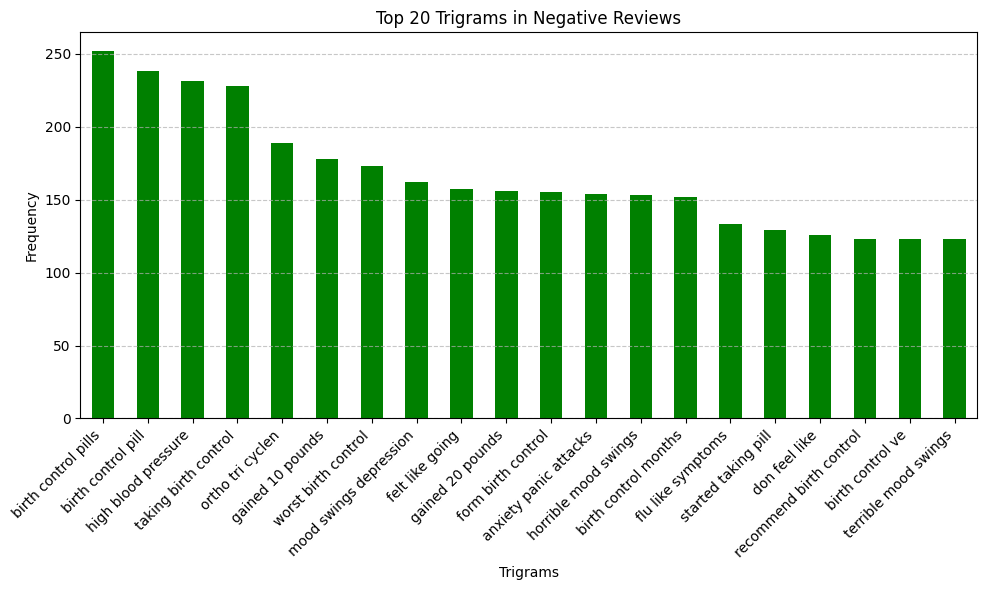

In [39]:
def plot_top_ngrams(text_series, ngram_range=(3, 3), color='green', title='Top Trigrams'):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english', max_features=20)
    X = vectorizer.fit_transform(text_series)
    freq_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    top_ngrams = freq_df.sum().sort_values(ascending=False)
    print(top_ngrams)

    plt.figure(figsize=(10, 6))
    top_ngrams.plot(kind='bar', color=color)
    plt.title(title)
    plt.xlabel('Trigrams')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_top_ngrams(negative_reviews['review_cleaned'], ngram_range=(3, 3), color='green', title='Top 20 Trigrams in Negative Reviews')


### Topic Modeling (LDA)
Using the Latent Dirichlet Allocation (LDA) algorithm to find hidden themes (topics) in the dataset.
Each topic is a group of words that tend to appear together in documents.

In [40]:
from sklearn.decomposition import LatentDirichletAllocation

# Use CountVectorizer again
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X_counts = vectorizer.fit_transform(negative_reviews['review_cleaned'])

# Initialize LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 topics
lda.fit(X_counts)

# Show top words per topic
words = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[-10:][::-1]
    print(f"Topic {i+1}:")
    print([words[j] for j in top_words_idx])
    print()


Topic 1:
['effects', 'anxiety', 'taking', 'medication', 'drug', 'years', 'depression', 'months', 'started', 'doctor']

Topic 2:
['bleeding', 'period', 'months', 'got', 'month', 'days', 'weeks', 'shot', 'started', 'having']

Topic 3:
['pill', 've', 'months', 'control', 'weight', 'acne', 'birth', 'month', 'taking', 'started']

Topic 4:
['pain', 'day', 'taking', 'days', 'took', 'doctor', 'severe', 'stomach', 'started', 'medication']

Topic 5:
['like', 'day', 'night', 'just', 'sleep', 'work', 'feel', 'time', 'took', 'don']



**What Do These “Topics” Mean?**


Possible Themes: 
- Topic 1:
Mental health & medication effects

- Topic 2:
Menstrual/period-related issues

- Topic 3:
Birth control side effects (acne, weight)

- Topic 4:
Pain & doctor visits

- Topic 5:
Daily discomfort, sleep issues

#### Topic Wordcloud

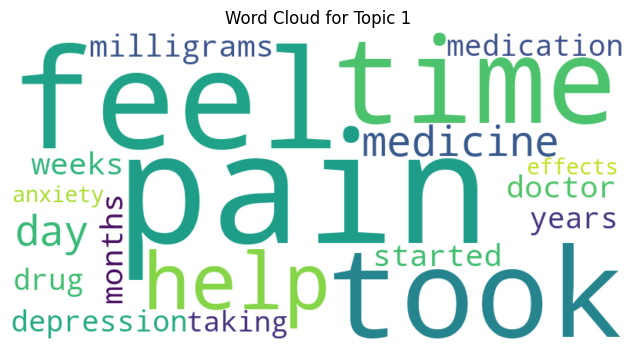

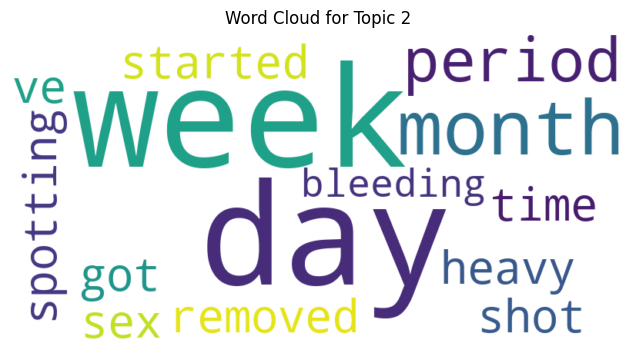

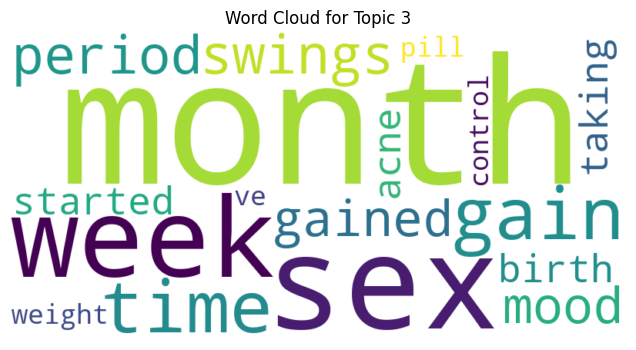

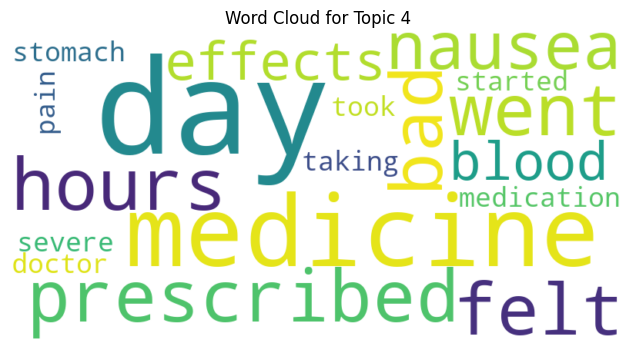

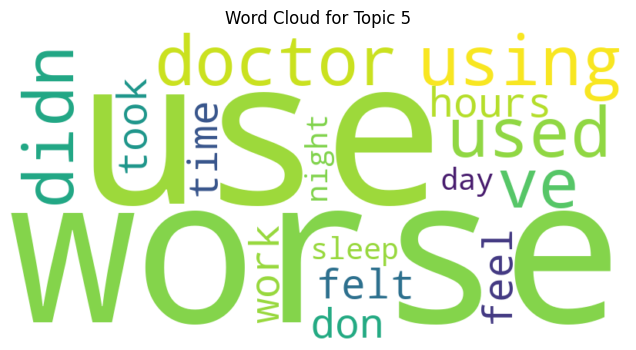

In [42]:
from wordcloud import WordCloud

# Generating word clouds for each topic
for i, topic in enumerate(lda.components_):
    topic_words = [words[j] for j in topic.argsort()[-20:]]
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(topic_words))
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Topic {i+1}')
    plt.show()


### Histogram of the Sentiment Polarity Distribution in the Negative Reviews



/var/folders/68/hprt_lq14j15tgjr6zxrgmch0000gn/T/ipykernel_36563/2427888261.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews.loc[:, 'polarity'] = negative_reviews['review_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)


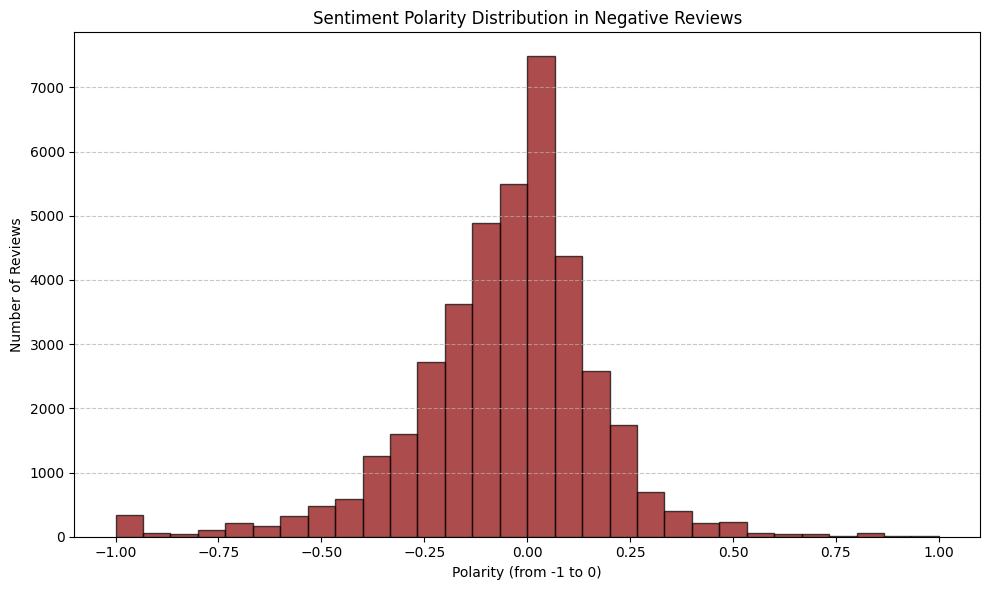

In [43]:
from textblob import TextBlob

# Calculate sentiment polarity
negative_reviews.loc[:, 'polarity'] = negative_reviews['review_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Visualize sentiment polarity
plt.figure(figsize=(10, 6))
plt.hist(negative_reviews['polarity'], bins=30, color='darkred', edgecolor='black', alpha=0.7)
plt.title('Sentiment Polarity Distribution in Negative Reviews')
plt.xlabel('Polarity (from -1 to 0)')
plt.ylabel('Number of Reviews')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Although these are all negative reviews, there’s a range of negativity:

- Some reviews are just slightly negative (near 0)

- Others are deeply negative (closer to -1)

- A few even cross into positive (likely due to mixed experiences in a review)

